In [1]:
import yfinance as yf
import pandas as pd
import requests
import matplotlib.pyplot as plt
import time

# ============
# 1. Sectores recomendados según Gregorio
# ============
sectores_recomendados = {
    "Utilities": {"PER": (10, 20), "Payout": (0.5, 0.8), "DeudaEBITDA": 4},
    "Consumer Defensive": {"PER": (15, 25), "Payout": (0.4, 0.7), "DeudaEBITDA": 3},
    "Healthcare": {"PER": (15, 25), "Payout": (0.3, 0.6), "DeudaEBITDA": 3},
    "Financial Services": {"PER": (8, 15), "Payout": (0.3, 0.6), "DeudaEBITDA": 15}, # banca especial
    "Communication Services": {"PER": (10, 20), "Payout": (0.4, 0.7), "DeudaEBITDA": 3},
    "Industrials": {"PER": (10, 20), "Payout": (0.4, 0.7), "DeudaEBITDA": 4}, # infraestructuras
}


# ============
# 2. Funciones de ayuda
# ============

def calcular_ratios(info):
    per = info.get("trailingPE")
    payout = info.get("payoutRatio")
    deuda = info.get("totalDebt")
    ebitda = info.get("ebitda")

    deuda_ebitda = None
    if deuda and ebitda and ebitda > 0:
        deuda_ebitda = deuda / ebitda

    return per, payout, deuda_ebitda

def cumple_ratios(sector, per, payout, deuda_ebitda):
    if sector not in sectores_recomendados:
        return False
    reglas = sectores_recomendados[sector]

    ok_per = per and reglas["PER"][0] <= per <= reglas["PER"][1]
    ok_payout = payout and reglas["Payout"][0] <= payout <= reglas["Payout"][1]
    ok_deuda = deuda_ebitda and deuda_ebitda <= reglas["DeudaEBITDA"]

    return ok_per and ok_payout and ok_deuda


# ============
# 3. Descargar listas de tickers automáticamente
# ============

def obtener_sp500():
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    headers = {"User-Agent": "Mozilla/5.0"}
    html = requests.get(url, headers=headers).text
    tabla = pd.read_html(html, header=0)[0]
    return tabla["Symbol"].tolist()

def obtener_ibex35():
    url = "https://en.wikipedia.org/wiki/IBEX_35"
    headers = {"User-Agent": "Mozilla/5.0"}
    html = requests.get(url, headers=headers).text
    tablas = pd.read_html(html, header=0)
    tabla = tablas[1]  # la segunda tabla contiene los componentes
    return tablas[2].iloc[:,0].tolist()

# ============
# 4. Analizar empresas según filtros del libro
# ============

def analizar_empresa(ticker, años_hist=5):
    try:
        empresa = yf.Ticker(ticker)
        info = empresa.info

        eps = info.get("trailingEps")
        dividend_yield = info.get("dividendYield")
        dividendos = empresa.dividends

        # Filtro de crecimiento de dividendos
        crecimiento_div = False
        if not dividendos.empty:
            dividendos = dividendos.resample("YE").sum()  # dividendos anuales
            if len(dividendos) >= años_hist:
                div_inicio = dividendos.iloc[-años_hist]
                div_fin = dividendos.iloc[-1]
                crecimiento_div = div_fin > div_inicio
        
        # Sector
        sector = info.get("sector")
        industria = info.get("industry")

        # Ratios
        per, payout, deuda_ebitda = calcular_ratios(info)
        ratios_ok = cumple_ratios(sector, per, payout, deuda_ebitda)

        return {
            "Ticker": ticker,
            "Sector": sector,
            "Industria": industria,
            "EPS": eps,
            "Dividend Yield": dividend_yield,
            "Rentable": eps is not None and eps > 0,
            "Paga Dividendos": dividend_yield is not None and dividend_yield > 0,
            "Historial Dividendos": not dividendos.empty,
            "Dividendo Creciente": crecimiento_div,
            "PER": per,
            "Payout": payout,
            "Deuda/EBITDA": deuda_ebitda,
            "Ratios OK": ratios_ok
        }
    except Exception as e:
            print(f"Error con {ticker}: {e}")
            return None # Devuelve None si hay un error para filtrarlo después
        
def filtrar_empresas(lista_tickers, años_hist=5):
    resultados = []
    for t in lista_tickers:
        try:
            resultados.append(analizar_empresa(t, años_hist))
        except Exception as e:
            print(f"Error con {t}: {e}")
    df = pd.DataFrame(resultados)
    df_filtrado = df[df["Rentable"] & df["Paga Dividendos"] &
                     df["Historial Dividendos"] & df["Dividendo Creciente"] &
                     df["Ratios OK"]]
    return df, df_filtrado



# ============
# 4. Ejecutar ejemplo
# ============

# S&P 500
print("Iniciando análisis del IBEX 35...")
start_time_ibex = time.time()
sp500_tickers = obtener_sp500()
df_sp500, sp500_filtradas = filtrar_empresas(sp500_tickers)

# IBEX 35

ibex_tickers = obtener_ibex35()
df_ibex, ibex_filtradas = filtrar_empresas(ibex_tickers)
end_time_ibex = time.time() 
tiempo_ibex = end_time_ibex - start_time_ibex
print(f"\n✅ Análisis del IBEX 35 y SP 500 finalizado en {tiempo_ibex:.2f} segundos.")
print("✅ S&P 500 - Empresas que cumplen los filtros:")
print(sp500_filtradas[["Ticker", "EPS", "Dividend Yield"]])

print("\n✅ IBEX 35 - Empresas que cumplen los filtros:")
print(ibex_filtradas[["Ticker", "EPS", "Dividend Yield"]])


Iniciando análisis del IBEX 35...


/tmp/ipykernel_8022/1252876842.py:56: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tabla = pd.read_html(html, header=0)[0]
$BRK.B: possibly delisted; no timezone found
$BF.B: possibly delisted; no price data found  (1d 1926-11-06 -> 2025-10-12)
/tmp/ipykernel_8022/1252876842.py:63: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tablas = pd.read_html(html, header=0)
HTTP Error 500: {"quoteSummary":{"result":null,"error":{"code":"internal-error","description":"internal-error"}}}



✅ Análisis del IBEX 35 y SP 500 finalizado en 395.03 segundos.
✅ S&P 500 - Empresas que cumplen los filtros:
    Ticker    EPS  Dividend Yield
84     CAH   6.45            1.30
103     CI  18.25            2.01
120    STZ   6.87            2.89
417    SNA  18.76            2.62
464    UNH  23.11            2.49
502    ZTS   5.81            1.42

✅ IBEX 35 - Empresas que cumplen los filtros:
     Ticker   EPS  Dividend Yield
10  AENA.MC  1.86            4.28
28  ROVI.MC  2.59            1.64


In [3]:
df_sp500

,Ticker,Sector,Industria,EPS,Dividend Yield,Rentable,Paga Dividendos,Historial Dividendos,Dividendo Creciente,PER,Payout,Deuda/EBITDA,Ratios OK
0,MMM,Industrials,Conglomerates,7.20,1.96,True,True,True,False,20.659723,0.3972,2.378257,False
1,AOS,Industrials,Specialty Industrial Machinery,3.59,2.01,True,True,True,False,18.871866,0.3733,0.433407,False
2,ABT,Healthcare,Medical Devices,7.97,1.78,True,True,True,False,16.633627,0.2861,1.176111,False
3,ABBV,Healthcare,Drug Manufacturers - General,2.10,2.85,True,True,True,False,109.761910,3.0381,2.514248,False
4,ACN,Technology,Information Technology Services,12.14,2.71,True,True,True,True,19.846786,0.4872,0.669490,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,XYL,Industrials,Specialty Industrial Machinery,3.84,1.11,True,True,True,True,37.583336,0.3958,1.191919,False
499,YUM,Consumer Cyclical,Restaurants,5.07,2.01,True,True,True,True,27.932938,0.5444,4.461956,False
500,ZBRA,Technology,Communication Equipment,10.59,NaN,True,False,False,False,26.051937,0.0000,2.408163,False
501,ZBH,Healthcare,Medical Devices,4.10,1.01,True,True,True,False,23.100000,0.2341,2.982886,False


In [76]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# ====================
# Funciones auxiliares
# ====================

def estadisticas_ratio(serie):
    """Calcula media, mediana, desviación, p25 y p75 de una lista de ratios."""
    if len(serie) == 0:
        return None, None, None, None, None
    serie = [x for x in serie if x is not None]
    if len(serie) == 0:
        return None, None, None, None, None

    media = np.mean(serie)
    mediana = np.median(serie)
    std = np.std(serie)
    p25 = np.percentile(serie, 25)
    p75 = np.percentile(serie, 75)

    return media, mediana, std, p25, p75

def filtrar_empresas(lista_tickers, años_hist=5):
    resultados = []
    for t in lista_tickers:
        try:
            resultados.append(analizar_empresa(t, años_hist))
        except Exception as e:
            print(f"Error con {t}: {e}")
    df = pd.DataFrame(resultados)
    df_filtrado = df[df["Rentable"] & df["Paga Dividendos"] &
                     df["Historial Dividendos"] & df["Dividendo Creciente"] &
                     df["Ratios OK"]]
    return df, df_filtrado


# ====================
# Análisis de empresa
# ====================

def analizar_empresa_avanzado(ticker, años_hist=5):
    empresa = yf.Ticker(ticker)
    info = empresa.info

    # Ratios actuales
    per = info.get("trailingPE")
    payout = info.get("payoutRatio")
    dividend_yield = info.get("dividendYield")
    deuda = info.get("totalDebt")
    ebitda = info.get("ebitda")
    deuda_ebitda = deuda/ebitda if deuda and ebitda and ebitda > 0 else None
    eps_actual = info.get("trailingEps")

    # Ratios históricos
    hist = empresa.financials.T
    hist_ratios = {"PER": {}, "Payout": {}, "Deuda/EBITDA": {}, "Dividend Yield": {}, "EPS": {}}

    precio = info.get("currentPrice")
    acciones = info.get("sharesOutstanding")

    try:
        for fecha in hist.index[:años_hist]:
            beneficios = hist.loc[fecha, "Net Income"] if "Net Income" in hist.columns else None
            eps = beneficios/acciones if beneficios and acciones else None
            if eps and eps > 0:
                hist_ratios["EPS"][fecha.year] = eps
                hist_ratios["PER"][fecha.year] = precio/eps

            dividendos = empresa.dividends[empresa.dividends.index.year == fecha.year].sum()
            if eps and eps > 0 and dividendos > 0:
                hist_ratios["Payout"][fecha.year] = dividendos/eps
            if precio and dividendos > 0:
                hist_ratios["Dividend Yield"][fecha.year] = dividendos/precio

            deuda_hist = info.get("totalDebt")
            ebitda_hist = hist.loc[fecha, "EBITDA"] if "EBITDA" in hist.columns else None
            if deuda_hist and ebitda_hist and ebitda_hist > 0:
                hist_ratios["Deuda/EBITDA"][fecha.year] = deuda_hist/ebitda_hist
    except Exception as e:
        print(f"Error procesando históricos de {ticker}: {e}")

    return {
        "Ticker": ticker,
        "Sector": info.get("sector"),
        "Industria": info.get("industry"),
        "PER actual": per,
        "Payout actual": payout,
        "Deuda/EBITDA actual": deuda_ebitda,
        "Dividend Yield actual": dividend_yield,
        "EPS actual": eps_actual,
        "PER (stats)": estadisticas_ratio(list(hist_ratios["PER"].values())),
        "Payout (stats)": estadisticas_ratio(list(hist_ratios["Payout"].values())),
        "Deuda/EBITDA (stats)": estadisticas_ratio(list(hist_ratios["Deuda/EBITDA"].values())),
        "Dividend Yield (stats)": estadisticas_ratio(list(hist_ratios["Dividend Yield"].values())),
        "EPS (stats)": estadisticas_ratio(list(hist_ratios["EPS"].values())),
        "Históricos": hist_ratios
    }

# ====================
# Dashboard combinado
# ====================

def graficar_dashboard_ratios(ticker, analisis):
    """Dashboard único: arriba boxplot, abajo evolución histórica para cada ratio."""
    ratios = {
        "PER": (analisis["PER actual"], analisis["PER (stats)"], analisis["Históricos"]["PER"]),
        "Payout": (analisis["Payout actual"], analisis["Payout (stats)"], analisis["Históricos"]["Payout"]),
        "Deuda/EBITDA": (analisis["Deuda/EBITDA actual"], analisis["Deuda/EBITDA (stats)"], analisis["Históricos"]["Deuda/EBITDA"]),
        "Dividend Yield": (analisis["Dividend Yield actual"], analisis["Dividend Yield (stats)"], analisis["Históricos"]["Dividend Yield"]),
        "EPS": (analisis["EPS actual"], analisis["EPS (stats)"], analisis["Históricos"]["EPS"])
    }

    n = len(ratios)
    fig, axes = plt.subplots(n, 2, figsize=(12, n*3))
    
    if n == 1:
        axes = np.array([axes])  # manejo de caso especial

    for i, (nombre, (actual, stats, serie)) in enumerate(ratios.items()):
        # Columna izquierda: boxplot simplificado
        ax_box = axes[i, 0]
        if stats is None or stats[0] is None:
            ax_box.set_title(f"{nombre} - {ticker}\n(No hay datos)")
            ax_box.axis("off")
        else:
            media, mediana, std, p25, p75 = stats
            ax_box.fill_between([0.8, 1.2], p25, p75, color="green", alpha=0.2, label="Rango 25-75%")
            ax_box.scatter(1, mediana, color="blue", marker="|", s=200, label="Mediana histórica")
            if actual is not None:
                ax_box.scatter(1, actual, color="red", s=100, zorder=5, label="Valor actual")
            ax_box.set_xticks([1])
            ax_box.set_xticklabels([nombre])
            ax_box.set_ylabel("Valor")
            ax_box.set_title(f"{nombre} - Boxplot")
            ax_box.grid(True, linestyle="--", alpha=0.5)
            ax_box.legend()

        # Columna derecha: evolución temporal
        ax_evo = axes[i, 1]
        if not serie:
            ax_evo.set_title(f"{nombre} - {ticker}\n(No hay datos)")
            ax_evo.axis("off")
        else:
            años = list(serie.keys())
            valores = list(serie.values())
            ax_evo.plot(años, valores, marker="o", color="blue", label="Histórico")
            if actual is not None:
                ax_evo.axhline(actual, color="red", linestyle="--", label="Actual")
            ax_evo.set_title(f"{nombre} - Evolución")
            ax_evo.set_xlabel("Año")
            ax_evo.set_ylabel("Valor")
            ax_evo.grid(True, linestyle="--", alpha=0.5)
            ax_evo.legend()

    plt.suptitle(f"Dashboard de Ratios - {ticker}", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

    
# ============
# 4. Ejecutar ejemplo
# ============

# S&P 500
print("Iniciando análisis del IBEX 35...")
start_time_ibex = time.time()
sp500_tickers = obtener_sp500()
df_sp500, sp500_filtradas = filtrar_empresas(sp500_tickers)

# IBEX 35

ibex_tickers = obtener_ibex35()
df_ibex, ibex_filtradas = filtrar_empresas(ibex_tickers)
end_time_ibex = time.time() 
tiempo_ibex = end_time_ibex - start_time_ibex
print(f"\n✅ Análisis del IBEX 35 y SP 500 finalizado en {tiempo_ibex:.2f} segundos.")
print("✅ S&P 500 - Empresas que cumplen los filtros:")
print(sp500_filtradas[["Ticker", "EPS", "Dividend Yield"]])

print("\n✅ IBEX 35 - Empresas que cumplen los filtros:")
print(ibex_filtradas[["Ticker", "EPS", "Dividend Yield"]])

Iniciando análisis del IBEX 35...


/tmp/ipykernel_2816/3295305489.py:58: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tabla = pd.read_html(html, header=0)[0]
$BRK.B: possibly delisted; no timezone found
$BF.B: possibly delisted; no price data found  (1d 1926-10-19 -> 2025-09-24)
/tmp/ipykernel_2816/3295305489.py:65: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tablas = pd.read_html(html, header=0)
HTTP Error 500: 



✅ Análisis del IBEX 35 y SP 500 finalizado en 425.60 segundos.
✅ S&P 500 - Empresas que cumplen los filtros:
    Ticker    EPS  Dividend Yield
27     AIG   5.35            2.35
103     CI  18.25            2.08
417    SNA  18.78            2.52
464    UNH  23.09            2.54
502    ZTS   5.80            1.40

✅ IBEX 35 - Empresas que cumplen los filtros:
     Ticker   EPS  Dividend Yield
10  AENA.MC  1.86            4.19
28  ROVI.MC  2.59            1.59


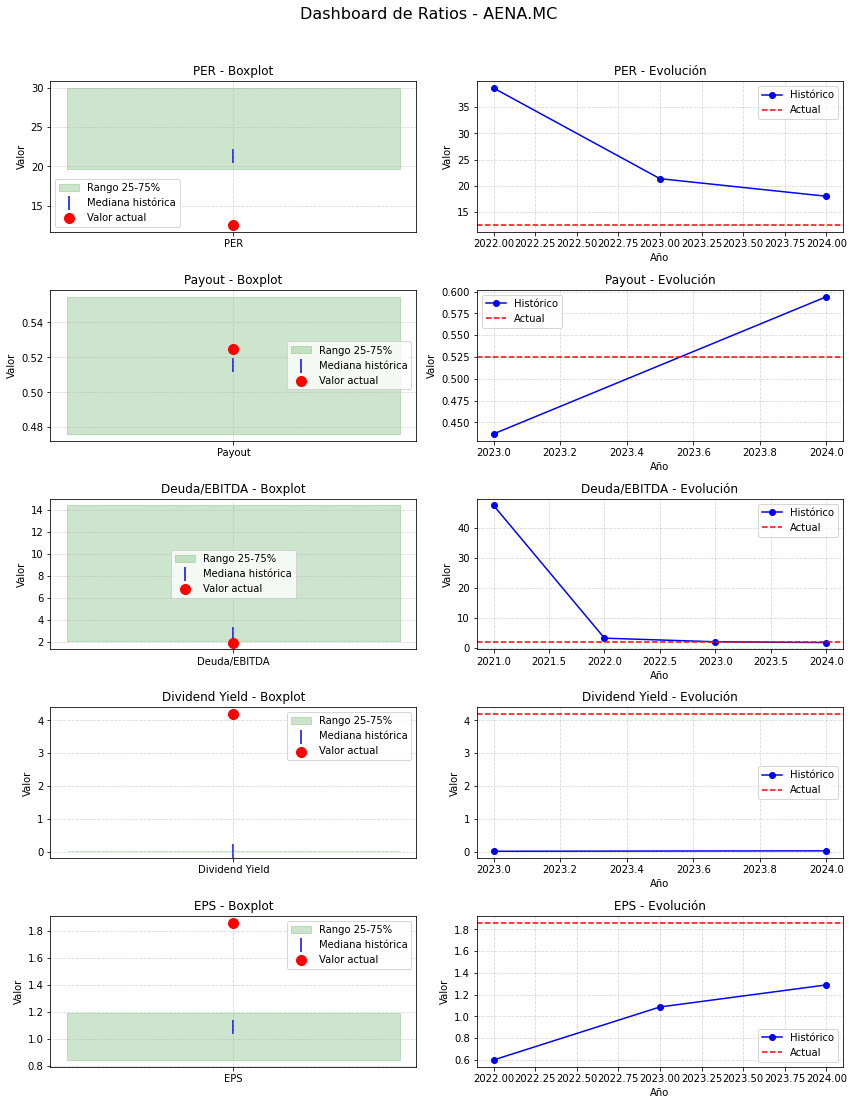

In [77]:
res = analizar_empresa_avanzado("AENA.MC", años_hist=10)
graficar_dashboard_ratios("AENA.MC", res)


Iniciando análisis...


/tmp/ipykernel_8022/3295305489.py:58: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tabla = pd.read_html(html, header=0)[0]
$BRK.B: possibly delisted; no timezone found
$BF.B: possibly delisted; no price data found  (1d 1926-11-06 -> 2025-10-12)
/tmp/ipykernel_8022/3295305489.py:65: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tablas = pd.read_html(html, header=0)
HTTP Error 500: {"quoteSummary":{"result":null,"error":{"code":"internal-error","description":"internal-error"}}}



✅ Análisis finalizado en 395.92 segundos.
✅ S&P 500 - Empresas que cumplen filtros:
    Ticker    EPS  Dividend Yield
84     CAH   6.45            1.30
103     CI  18.25            2.01
120    STZ   6.87            2.89
417    SNA  18.76            2.62
464    UNH  23.11            2.49

✅ IBEX 35 - Empresas que cumplen filtros:
     Ticker   EPS  Dividend Yield
10  AENA.MC  1.86            4.28
28  ROVI.MC  2.59            1.64


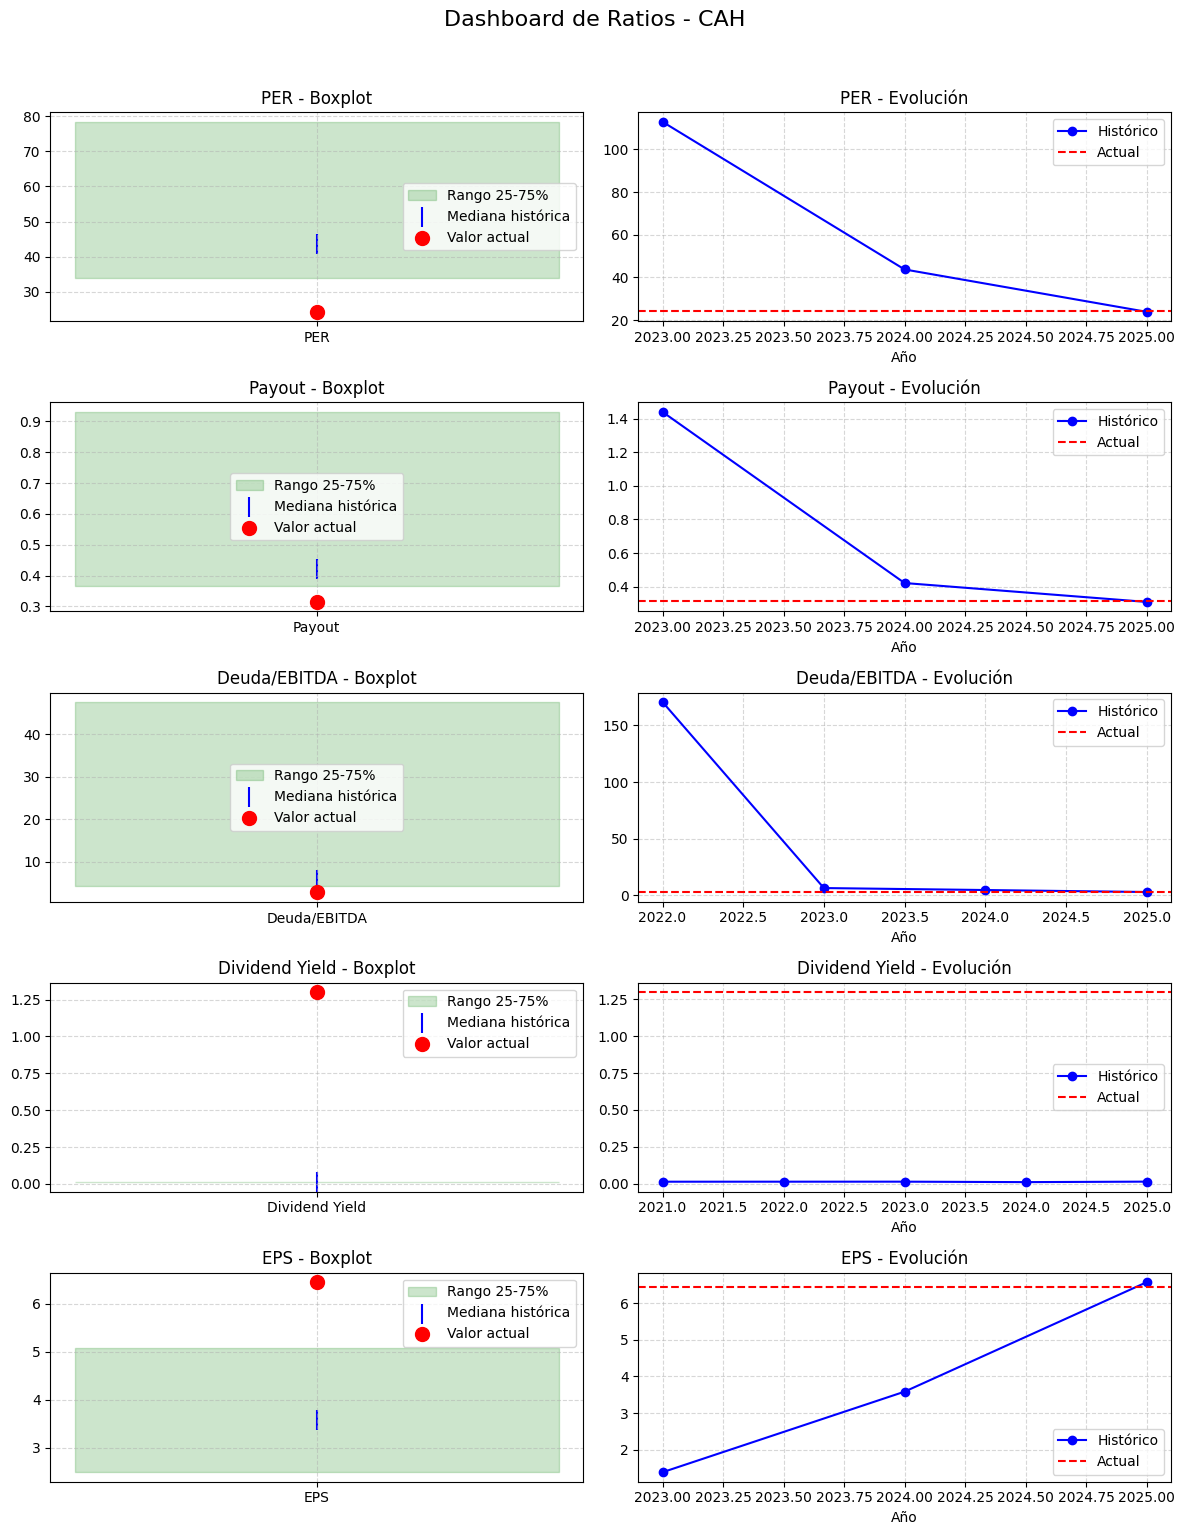

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import time

# ============
# 1. Sectores recomendados según Gregorio
# ============
sectores_recomendados = {
    "Utilities": {"PER": (10, 20), "Payout": (0.5, 0.8), "DeudaEBITDA": 4},
    "Consumer Defensive": {"PER": (15, 25), "Payout": (0.4, 0.7), "DeudaEBITDA": 3},
    "Healthcare": {"PER": (15, 25), "Payout": (0.3, 0.6), "DeudaEBITDA": 3},
    "Financial Services": {"PER": (8, 15), "Payout": (0.3, 0.6), "DeudaEBITDA": 15}, # banca especial
    "Communication Services": {"PER": (10, 20), "Payout": (0.4, 0.7), "DeudaEBITDA": 3},
    "Industrials": {"PER": (10, 20), "Payout": (0.4, 0.7), "DeudaEBITDA": 4}, # infraestructuras
}

# ============
# 2. Funciones auxiliares
# ============

def estadisticas_ratio(serie):
    if len(serie) == 0:
        return None, None, None, None, None
    serie = [x for x in serie if x is not None]
    if len(serie) == 0:
        return None, None, None, None, None
    return (np.mean(serie), np.median(serie), np.std(serie),
            np.percentile(serie, 25), np.percentile(serie, 75))

def calcular_ratios(info):
    per = info.get("trailingPE")
    payout = info.get("payoutRatio")
    deuda = info.get("totalDebt")
    ebitda = info.get("ebitda")
    deuda_ebitda = deuda / ebitda if deuda and ebitda and ebitda > 0 else None
    return per, payout, deuda_ebitda

def cumple_ratios(sector, per, payout, deuda_ebitda):
    if sector not in sectores_recomendados:
        return False
    reglas = sectores_recomendados[sector]
    ok_per = per and reglas["PER"][0] <= per <= reglas["PER"][1]
    ok_payout = payout and reglas["Payout"][0] <= payout <= reglas["Payout"][1]
    ok_deuda = deuda_ebitda and deuda_ebitda <= reglas["DeudaEBITDA"]
    return ok_per and ok_payout and ok_deuda

# ============
# 3. Descargar listas de tickers
# ============

def obtener_sp500():
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    headers = {"User-Agent": "Mozilla/5.0"}
    html = requests.get(url, headers=headers).text
    tabla = pd.read_html(html, header=0)[0]
    return tabla["Symbol"].tolist()

def obtener_ibex35():
    url = "https://en.wikipedia.org/wiki/IBEX_35"
    headers = {"User-Agent": "Mozilla/5.0"}
    html = requests.get(url, headers=headers).text
    tablas = pd.read_html(html, header=0)
    return tablas[2].iloc[:, 0].tolist()  # tabla con tickers

# ============
# 4. Análisis de empresa básico
# ============

def analizar_empresa(ticker, años_hist=5):
    try:
        empresa = yf.Ticker(ticker)
        info = empresa.info

        eps = info.get("trailingEps")
        dividend_yield = info.get("dividendYield")
        dividendos = empresa.dividends

        crecimiento_div = False
        if not dividendos.empty:
            dividendos = dividendos.resample("YE").sum()
            if len(dividendos) >= años_hist:
                crecimiento_div = dividendos.iloc[-1] > dividendos.iloc[-años_hist]

        sector = info.get("sector")
        industria = info.get("industry")

        per, payout, deuda_ebitda = calcular_ratios(info)
        ratios_ok = cumple_ratios(sector, per, payout, deuda_ebitda)

        return {
            "Ticker": ticker,
            "Sector": sector,
            "Industria": industria,
            "EPS": eps,
            "Dividend Yield": dividend_yield,
            "Rentable": eps is not None and eps > 0,
            "Paga Dividendos": dividend_yield is not None and dividend_yield > 0,
            "Historial Dividendos": not dividendos.empty,
            "Dividendo Creciente": crecimiento_div,
            "PER": per,
            "Payout": payout,
            "Deuda/EBITDA": deuda_ebitda,
            "Ratios OK": ratios_ok
        }
    except Exception:
        return None

def filtrar_empresas(lista_tickers, años_hist=5):
    resultados = [analizar_empresa(t, años_hist) for t in lista_tickers]
    df = pd.DataFrame([r for r in resultados if r is not None])
    df_filtrado = df[df["Rentable"] & df["Paga Dividendos"] &
                     df["Historial Dividendos"] & df["Dividendo Creciente"] &
                     df["Ratios OK"]]
    return df, df_filtrado

# ============
# 5. Análisis avanzado con históricos y estadísticas
# ============

def analizar_empresa_avanzado(ticker, años_hist=5):
    empresa = yf.Ticker(ticker)
    info = empresa.info

    per = info.get("trailingPE")
    payout = info.get("payoutRatio")
    dividend_yield = info.get("dividendYield")
    deuda = info.get("totalDebt")
    ebitda = info.get("ebitda")
    deuda_ebitda = deuda / ebitda if deuda and ebitda and ebitda > 0 else None
    eps_actual = info.get("trailingEps")

    hist = empresa.financials.T
    hist_ratios = {k: {} for k in ["PER", "Payout", "Deuda/EBITDA", "Dividend Yield", "EPS"]}

    precio = info.get("currentPrice")
    acciones = info.get("sharesOutstanding")

    try:
        for fecha in hist.index[:años_hist]:
            beneficios = hist.loc[fecha, "Net Income"] if "Net Income" in hist.columns else None
            eps = beneficios/acciones if beneficios and acciones else None
            if eps and eps > 0:
                hist_ratios["EPS"][fecha.year] = eps
                hist_ratios["PER"][fecha.year] = precio/eps

            dividendos = empresa.dividends[empresa.dividends.index.year == fecha.year].sum()
            if eps and eps > 0 and dividendos > 0:
                hist_ratios["Payout"][fecha.year] = dividendos/eps
            if precio and dividendos > 0:
                hist_ratios["Dividend Yield"][fecha.year] = dividendos/precio

            deuda_hist = info.get("totalDebt")
            ebitda_hist = hist.loc[fecha, "EBITDA"] if "EBITDA" in hist.columns else None
            if deuda_hist and ebitda_hist and ebitda_hist > 0:
                hist_ratios["Deuda/EBITDA"][fecha.year] = deuda_hist/ebitda_hist
    except Exception:
        pass

    return {
        "Ticker": ticker,
        "Sector": info.get("sector"),
        "Industria": info.get("industry"),
        "PER actual": per,
        "Payout actual": payout,
        "Deuda/EBITDA actual": deuda_ebitda,
        "Dividend Yield actual": dividend_yield,
        "EPS actual": eps_actual,
        "PER (stats)": estadisticas_ratio(list(hist_ratios["PER"].values())),
        "Payout (stats)": estadisticas_ratio(list(hist_ratios["Payout"].values())),
        "Deuda/EBITDA (stats)": estadisticas_ratio(list(hist_ratios["Deuda/EBITDA"].values())),
        "Dividend Yield (stats)": estadisticas_ratio(list(hist_ratios["Dividend Yield"].values())),
        "EPS (stats)": estadisticas_ratio(list(hist_ratios["EPS"].values())),
        "Históricos": hist_ratios
    }

# ============
# 6. Dashboard gráfico
# ============

def graficar_dashboard_ratios(ticker, analisis):
    ratios = {
        "PER": (analisis["PER actual"], analisis["PER (stats)"], analisis["Históricos"]["PER"]),
        "Payout": (analisis["Payout actual"], analisis["Payout (stats)"], analisis["Históricos"]["Payout"]),
        "Deuda/EBITDA": (analisis["Deuda/EBITDA actual"], analisis["Deuda/EBITDA (stats)"], analisis["Históricos"]["Deuda/EBITDA"]),
        "Dividend Yield": (analisis["Dividend Yield actual"], analisis["Dividend Yield (stats)"], analisis["Históricos"]["Dividend Yield"]),
        "EPS": (analisis["EPS actual"], analisis["EPS (stats)"], analisis["Históricos"]["EPS"])
    }

    n = len(ratios)
    fig, axes = plt.subplots(n, 2, figsize=(12, n*3))

    for i, (nombre, (actual, stats, serie)) in enumerate(ratios.items()):
        # Boxplot simplificado
        ax_box = axes[i, 0]
        if stats and stats[0] is not None:
            _, mediana, _, p25, p75 = stats
            ax_box.fill_between([0.8, 1.2], p25, p75, color="green", alpha=0.2, label="Rango 25-75%")
            ax_box.scatter(1, mediana, color="blue", marker="|", s=200, label="Mediana histórica")
            if actual is not None:
                ax_box.scatter(1, actual, color="red", s=100, zorder=5, label="Valor actual")
        ax_box.set_xticks([1])
        ax_box.set_xticklabels([nombre])
        ax_box.set_title(f"{nombre} - Boxplot")
        ax_box.grid(True, linestyle="--", alpha=0.5)
        ax_box.legend()

        # Evolución temporal
        ax_evo = axes[i, 1]
        if serie:
            años = list(serie.keys())
            valores = list(serie.values())
            ax_evo.plot(años, valores, marker="o", color="blue", label="Histórico")
            if actual is not None:
                ax_evo.axhline(actual, color="red", linestyle="--", label="Actual")
        ax_evo.set_title(f"{nombre} - Evolución")
        ax_evo.set_xlabel("Año")
        ax_evo.grid(True, linestyle="--", alpha=0.5)
        ax_evo.legend()

    plt.suptitle(f"Dashboard de Ratios - {ticker}", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# ============
# 7. Ejemplo de ejecución
# ============

print("Iniciando análisis...")
start_time = time.time()

sp500_tickers = obtener_sp500()
df_sp500, sp500_filtradas = filtrar_empresas(sp500_tickers)

ibex_tickers = obtener_ibex35()
df_ibex, ibex_filtradas = filtrar_empresas(ibex_tickers)

end_time = time.time()
print(f"\n✅ Análisis finalizado en {end_time - start_time:.2f} segundos.")

print("✅ S&P 500 - Empresas que cumplen filtros:")
print(sp500_filtradas[["Ticker", "EPS", "Dividend Yield"]].head())

print("\n✅ IBEX 35 - Empresas que cumplen filtros:")
print(ibex_filtradas[["Ticker", "EPS", "Dividend Yield"]].head())

# Ejemplo de dashboard para una empresa filtrada
if not sp500_filtradas.empty:
    ejemplo = sp500_filtradas.iloc[0]["Ticker"]
    res = analizar_empresa_avanzado(ejemplo, años_hist=10)
    graficar_dashboard_ratios(ejemplo, res)


In [6]:
analizar_empresa_avanzado('CAH', años_hist=10)

{'Ticker': 'CAH',
 'Sector': 'Healthcare',
 'Industria': 'Medical Distribution',
 'PER actual': 24.322481,
 'Payout actual': 0.3143,
 'Deuda/EBITDA actual': 2.8683166634806803,
 'Dividend Yield actual': 1.3,
 'EPS actual': 6.45,
 'PER (stats)': (np.float64(60.18959852783869),
  np.float64(43.7464450142723),
  np.float64(38.17570969629986),
  np.float64(33.811714227879264),
  np.float64(78.34590607101492)),
 'Payout (stats)': (np.float64(0.7235507915072336),
  np.float64(0.4219044575892019),
  np.float64(0.508096583203706),
  np.float64(0.36573863980933513),
  np.float64(0.9305397762461162)),
 'Deuda/EBITDA (stats)': (np.float64(46.25558487442907),
  np.float64(5.65444432236397),
  np.float64(71.85343569807402),
  np.float64(4.344319390033299),
  np.float64(47.56570980675974)),
 'Dividend Yield (stats)': (np.float64(0.012090770015298319),
  np.float64(0.012614737378888323),
  np.float64(0.001233379220777897),
  np.float64(0.012487251402345743),
  np.float64(0.012742223355430904)),
 'EPS

In [38]:
analizar_empresa_avanzado(ejemplo, años_hist=10)

{'Ticker': 'AIG',
 'Sector': 'Financial Services',
 'Industria': 'Insurance - Diversified',
 'PER actual': 14.5243,
 'Payout actual': 0.3084,
 'Deuda/EBITDA actual': 1.1286115568320638,
 'Dividend Yield actual': 2.35,
 'EPS actual': 5.35,
 'PER (stats)': (6.7258001119073185,
  4.209064158110883,
  3.5994694624773516,
  4.18064373840723,
  8.01258850850919),
 'Payout (stats)': (0.11688119250447447,
  0.0693385086535641,
  0.06789870094920458,
  0.06887032155934691,
  0.14112072152414684),
 'Deuda/EBITDA (stats)': (None, None, None, None, None),
 'Dividend Yield (stats)': (0.017503217503217504,
  0.016473616473616472,
  0.0014192070787222885,
  0.016473616473616472,
  0.018018018018018018),
 'EPS (stats)': (14.582931147500148,
  18.46016052054512,
  5.662860196673253,
  12.517963548448265,
  18.58651343307452),
 'Históricos': {'PER': {2023: 11.816112858907495,
   2022: 4.209064158110883,
   2021: 4.152223318703578},
  'Payout': {2023: 0.2129029343947296,
   2022: 0.0693385086535641,
   2

In [70]:
empresa = yf.Ticker('AIG')
info = empresa.info
info.get("dividendYield")
empresa.dividends

info.get("currentPrice")
# info.get("sharesOutstanding")

77.9

In [75]:
empresa.get_financials()

,2024-12-31,2023-12-31,2022-12-31,2021-12-31,2020-12-31
TaxEffectOfUnusualItems,1.818040e+08,3.520000e+05,-1.067040e+08,4.858650e+08,NaN
TaxRateForCalcs,3.020000e-01,4.400000e-02,2.340000e-01,1.830000e-01,NaN
TotalUnusualItems,6.020000e+08,8.000000e+06,-4.560000e+08,2.655000e+09,NaN
TotalUnusualItemsExcludingGoodwill,6.020000e+08,8.000000e+06,-4.560000e+08,2.655000e+09,NaN
NetIncomeFromContinuingOperationNetMinorityInterest,2.222000e+09,2.506000e+09,1.844000e+09,1.036700e+10,NaN
ReconciledDepreciation,3.597000e+09,3.841000e+09,3.861000e+09,4.542000e+09,NaN
EBIT,4.332000e+09,3.383000e+09,4.375000e+09,1.465200e+10,NaN
NetInterestIncome,-4.620000e+08,-5.160000e+08,-6.030000e+08,-1.305000e+09,NaN
InterestExpense,4.620000e+08,5.160000e+08,6.030000e+08,1.305000e+09,NaN
InterestIncome,2.610000e+08,3.210000e+08,2.910000e+08,1.740000e+09,NaN


In [68]:
def analizar_empresa_avanzado_1(ticker, años_hist=5):
    empresa = yf.Ticker(ticker)
    info = empresa.info

    # Ratios actuales
    per = info.get("trailingPE")
    payout = info.get("payoutRatio")
    dividend_yield = info.get("dividendYield")
    deuda = info.get("totalDebt")
    ebitda = info.get("ebitda")
    deuda_ebitda = deuda / ebitda if deuda and ebitda and ebitda > 0 else None
    eps_actual = info.get("trailingEps")

    # Descargar precios históricos (últimos años)
    precios_hist = yf.download(ticker, period=f"{años_hist+1}y", interval="1mo", progress=False)

    # Fix: aplanar MultiIndex si es necesario
    if isinstance(precios_hist.columns, pd.MultiIndex):
        precios_hist.columns = precios_hist.columns.droplevel(1)

    precios_hist = precios_hist["Adj Close"] if "Adj Close" in precios_hist.columns else precios_hist.iloc[:, 0]
    precios_anuales = precios_hist.resample("Y").last()  # precio de fin de año

    # Dividendos históricos (suma anual)
    dividendos_hist = empresa.dividends.resample("YE").sum()

    # EPS históricos de Yahoo (si existen)
    eps_yahoo = None
    try:
        if not empresa.earnings.empty:
            eps_yahoo = empresa.earnings["Earnings"] / empresa.earnings["Shares"]
            eps_yahoo.index = eps_yahoo.index.astype(int)  # asegurar que los años son int
    except Exception:
        pass

    # Ratios históricos
    hist_ratios = {k: {} for k in ["PER", "Payout", "Deuda/EBITDA", "Dividend Yield", "EPS"]}

    acciones = info.get("sharesOutstanding")

    for year in sorted(precios_anuales.index.year)[-años_hist:]:
        precio_year_series = precios_anuales.loc[str(year)] if str(year) in precios_anuales.index else None
    
        # Manejar el caso donde se devuelve una Serie
        if isinstance(precio_year_series, pd.Series):
            # Tomar el primer valor de la Serie y convertirlo a un solo número
            precio_year = precio_year_series.iloc[0]
        else:
            # Si ya es un valor escalar, úsalo directamente
            precio_year = precio_year_series

        # Ahora la verificación funciona correctamente con un solo valor
        if precio_year is None or np.isnan(precio_year):
            continue

        # EPS histórico
        if eps_yahoo is not None and year in eps_yahoo.index:
            eps = eps_yahoo.loc[year]
        else:
            beneficios = None
            if year in empresa.financials.columns and "Net Income" in empresa.financials.index:
                beneficios = empresa.financials.loc["Net Income", year]
            eps = beneficios / acciones if beneficios and acciones else None

        if eps and eps > 0:
            hist_ratios["EPS"][year] = eps
            hist_ratios["PER"][year] = precio_year / eps

        # Dividendos de ese año
        dividendos_serie = dividendos_hist.loc[str(year)] if str(year) in dividendos_hist.index else 0

        # Manejar el caso donde se devuelve una Serie
        if isinstance(dividendos_serie, pd.Series):
            # Sumar los dividendos si hay múltiples entradas
            dividendos = dividendos_serie.sum()
        else:
            # Si ya es un valor escalar, úsalo directamente
            dividendos = dividendos_serie

        # Ahora la verificación funciona correctamente con un solo valor
        if dividendos > 0:
            hist_ratios["Dividend Yield"][year] = dividendos / precio_year
            if eps and eps > 0:
                hist_ratios["Payout"][year] = dividendos / eps

        # Deuda/EBITDA (aprox, porque Yahoo no da histórico de deuda)
        deuda_hist = info.get("totalDebt")
        ebitda_hist = None
        if year in empresa.financials.columns and "EBITDA" in empresa.financials.index:
            ebitda_hist = empresa.financials.loc["EBITDA", year]
        if deuda_hist and ebitda_hist and ebitda_hist > 0:
            hist_ratios["Deuda/EBITDA"][year] = deuda_hist / ebitda_hist

    return {
        "Ticker": ticker,
        "Sector": info.get("sector"),
        "Industria": info.get("industry"),
        "PER actual": per,
        "Payout actual": payout,
        "Deuda/EBITDA actual": deuda_ebitda,
        "Dividend Yield actual": dividend_yield,
        "EPS actual": eps_actual,
        "PER (stats)": estadisticas_ratio(list(hist_ratios["PER"].values())),
        "Payout (stats)": estadisticas_ratio(list(hist_ratios["Payout"].values())),
        "Deuda/EBITDA (stats)": estadisticas_ratio(list(hist_ratios["Deuda/EBITDA"].values())),
        "Dividend Yield (stats)": estadisticas_ratio(list(hist_ratios["Dividend Yield"].values())),
        "EPS (stats)": estadisticas_ratio(list(hist_ratios["EPS"].values())),
        "Históricos": hist_ratios
    }



In [69]:
analizar_empresa_avanzado_1(ejemplo, años_hist=10)

/tmp/ipykernel_2816/3904108727.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  precios_hist = yf.download(ticker, period=f"{años_hist+1}y", interval="1mo", progress=False)
/tmp/ipykernel_2816/3904108727.py:22: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  precios_anuales = precios_hist.resample("Y").last()  # precio de fin de año
/tmp/ipykernel_2816/3904108727.py:25: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dividendos_hist = empresa.dividends.resample("Y").sum()
/home/alex/anaconda3/lib/python3.9/site-packages/yfinance/scrapers/fundamentals.py:36: DeprecationWarning: 'Ticker.earnings' is deprecated as not available via API. Look for "Net Income" in Ticker.income_stmt.
  warnings.warn("'Ticker.earnings' is deprecated as not available via API. Look for \"Net Income\" in Ticker.income_stmt.", DeprecationWarning)


{'Ticker': 'AIG',
 'Sector': 'Financial Services',
 'Industria': 'Insurance - Diversified',
 'PER actual': 14.560748,
 'Payout actual': 0.3084,
 'Deuda/EBITDA actual': 1.1286115568320638,
 'Dividend Yield actual': 2.35,
 'EPS actual': 5.35,
 'PER (stats)': (None, None, None, None, None),
 'Payout (stats)': (None, None, None, None, None),
 'Deuda/EBITDA (stats)': (None, None, None, None, None),
 'Dividend Yield (stats)': (0.026371002005652067,
  0.02462574683443716,
  0.006853224313470157,
  0.021699830301286662,
  0.028492397692392854),
 'EPS (stats)': (None, None, None, None, None),
 'Históricos': {'PER': {},
  'Payout': {},
  'Deuda/EBITDA': {},
  'Dividend Yield': {2016: 0.024617667325203166,
   2017: 0.02644130565130124,
   2018: 0.03906276644738527,
   2019: 0.029176095039423394,
   2020: 0.038000657081044865,
   2021: 0.02463382634367115,
   2022: 0.021635416270392154,
   2023: 0.02156115221355106,
   2024: 0.021893072393970186,
   2025: 0.01668806129057817},
  'EPS': {}}}

Claro, aquí tienes una explicación de las métricas financieras que obtuviste de Yahoo Finance para la empresa AIG. Estas son partidas de la **cuenta de resultados (Income Statement)**, que muestra los ingresos, gastos y beneficios de una empresa durante un período.

---

### Ingresos y Gastos de Operación

* **OperatingRevenue / TotalRevenue**: El ingreso total generado por las actividades principales del negocio.
* **NetPolicyholderBenefitsAndClaims**: Los pagos realizados a los asegurados por reclamaciones y beneficios. Es un gasto principal para una compañía de seguros como AIG.
* **LossAdjustmentExpense**: Los gastos incurridos para investigar, evaluar y resolver reclamaciones de seguros.
* **SellingGeneralAndAdministration / GeneralAndAdministrativeExpense**: Gastos no directamente relacionados con la producción, como salarios del personal administrativo, alquileres de oficinas y gastos de marketing.
* **OtherOperatingExpenses**: Otros gastos incurridos en el funcionamiento del negocio.
* **TotalExpenses**: La suma de todos los gastos operativos y no operativos.
* **EBIT**: Abreviatura de **Earnings Before Interest and Taxes** (Ganancias antes de intereses e impuestos). Mide la rentabilidad de las operaciones de la empresa, sin contar el impacto de la estructura de capital (intereses) y los impuestos.

---

### Partidas de Ingresos y Gastos No Operativos y Especiales

* **InterestIncome**: Ingresos generados por intereses de inversiones o préstamos.
* **InterestExpense**: Gastos incurridos por intereses de la deuda.
* **NetInterestIncome**: La diferencia entre los ingresos por intereses y los gastos por intereses.
* **OtherIncomeExpense**: Otros ingresos o gastos que no provienen de las operaciones principales.
* **SpecialIncomeCharges / OtherSpecialCharges**: Cargos o gastos extraordinarios, inusuales o no recurrentes que afectan a los beneficios.
* **TotalUnusualItems**: La suma de todos los elementos inusuales que han afectado a los ingresos.

---

### Partidas de Beneficio e Impuestos

* **PretaxIncome**: El beneficio de la empresa antes de pagar impuestos sobre la renta. Se calcula como `EBIT` menos los ingresos/gastos netos por intereses y otros ingresos/gastos no operativos.
* **TaxProvision / TaxRateForCalcs**: El monto de los impuestos que la empresa ha provisionado o pagado.
* **TaxEffectOfUnusualItems**: El impacto fiscal de las partidas inusuales.
* **NetIncomeContinuousOperations**: Los ingresos netos de las operaciones en curso de la empresa, después de restar los impuestos.
* **NetIncomeDiscontinuousOperations**: Los ingresos (o pérdidas) de las partes del negocio que han sido vendidas o cerradas.
* **NetIncomeIncludingNoncontrollingInterests**: El beneficio neto total de la empresa, incluyendo la parte que no pertenece a la empresa matriz (participaciones minoritarias).
* **NetIncome / NetIncomeCommonStockholders**: El beneficio neto final de la empresa después de todos los gastos, intereses e impuestos.
* **MinorityInterests**: La parte de los beneficios de una subsidiaria que pertenece a accionistas minoritarios.

---

### Partidas por Acción (Per-Share) y Acciones

* **BasicAverageShares**: El número promedio de acciones en circulación durante el período.
* **DilutedAverageShares**: El número promedio de acciones en circulación, incluyendo el impacto de opciones, warrants y otros instrumentos que podrían convertirse en acciones. Es un valor más conservador.
* **BasicEPS**: **Earnings Per Share** (Ganancias por Acción) básicas. Mide la parte del beneficio que corresponde a cada acción en circulación. Se calcula como `NetIncome` dividido por `BasicAverageShares`.
* **DilutedEPS**: Ganancias por Acción diluidas. Similar a Basic EPS, pero usando las acciones diluidas, lo que generalmente resulta en un número menor.
* **PreferredStockDividends**: Los dividendos pagados a los tenedores de acciones preferentes, los cuales se restan del beneficio antes de calcular las ganancias para los accionistas comunes.